<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Rio_Dengue_Risk_Classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

from numpy.lib.stride_tricks import sliding_window_view

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, Bidirectional, LSTM, Dropout, Dense, RepeatVector, TimeDistributed

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from itertools import product
from tensorflow.keras.optimizers import Adam

from tqdm.auto import tqdm
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.utils import to_categorical

from numpy.lib.stride_tricks import sliding_window_view


# from scikeras.wrappers import KerasClassifier, KerasRegressor
# from sklearn.model_selection import GridSearchCV

In [2]:
def get_data(ibge, ey_start, ey_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = ibge
  disease = "dengue"
  format = "csv"
  ew_start = 1
  ew_end = 53
  ey_start = ey_start
  ey_end = ey_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])
  dados = pd.read_csv(url_resp, index_col='SE')
  return dados

In [3]:
 # rio_neighbours_all = [3304557, 3302007, 3305554, 3303500,3301702, 3305109, 3300456, 3303203, 3302858, 3304144, 3302270, 3302858]
rio_neighbours = [3304557, 3302007, 3305554, 3303500, 3301702, 3305109, 3303203, 3302858]

In [4]:
geojson_url = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

muni = gpd.read_file(geojson_url)
muni["id"] = muni["id"].astype(str)

rio = muni[muni["id"].str.startswith("330")].copy() # Municipality rio ibge starts with 330
ribge = [str(x).zfill(7) for x in rio_neighbours]

rpl = pd.DataFrame({"ibge": rio["id"]})
rpl["selected"] = "other"
rpl.loc[rpl["ibge"].isin(ribge), "selected"] = "neighbour"
rpl.loc[rpl["ibge"] == "3304557", "selected"] = "rio_city"

fig = px.choropleth(
    rpl,
    geojson=rio.__geo_interface__,
    locations="ibge",
    featureidkey="properties.id",
    color="selected",
    color_discrete_map={
        "other":   "lightgrey",
        "neighbour": "orange",
        "rio_city": "maroon",
    }
)

fig.update_traces(marker_line_width=0.4, marker_line_color="black")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), coloraxis_showscale=False)

fig.show()


In [5]:
rj = []
for i, ibge in enumerate(rio_neighbours):
    data = get_data(ibge=ibge, ey_start=2010, ey_end=2024)
    data['region'] = f"r{i+1}"
    rj.append(data)

all = pd.concat(rj, ignore_index=True)

In [6]:
all.columns

Index(['data_iniSE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos',
       'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo',
       'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao',
       'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov',
       'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf',
       'notif_accum_year', 'region'],
      dtype='object')

In [7]:
all.head(5)

,data_iniSE,casos_est,casos_est_min,casos_est_max,casos,p_rt1,p_inc100k,Localidade_id,nivel,id,...,umidmin,tempmed,tempmax,casprov,casprov_est,casprov_est_min,casprov_est_max,casconf,notif_accum_year,region
0,2024-12-22,243.0,243,243.0,243,0.001278,3.667454,0,2,330455720245220363,...,70.152700,25.307686,28.246443,135.0,NaN,NaN,NaN,NaN,638433,r1
1,2024-12-15,270.0,270,270.0,270,0.005254,4.074949,0,2,330455720245120363,...,61.547200,25.614957,29.473357,148.0,NaN,NaN,NaN,NaN,638433,r1
2,2024-12-08,336.0,336,336.0,336,0.605330,5.071048,0,2,330455720245020363,...,63.694529,24.645686,28.808371,178.0,NaN,NaN,NaN,NaN,638433,r1
3,2024-12-01,335.0,335,335.0,335,0.860020,5.055956,0,2,330455720244920363,...,63.887829,25.732543,29.777914,180.0,NaN,NaN,NaN,NaN,638433,r1
4,2024-11-24,354.0,354,354.0,354,0.975968,5.342711,0,1,330455720244820363,...,52.232800,24.950714,29.700743,196.0,NaN,NaN,NaN,NaN,638433,r1


## Data Exploration

Because I want to learn how to predict the nivel, and the source uses
1. Weather
2. Twitter
3. Reported Cases

In [8]:
all.columns

Index(['data_iniSE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos',
       'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo',
       'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao',
       'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov',
       'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf',
       'notif_accum_year', 'region'],
      dtype='object')

In [9]:
cols = ['data_iniSE', 'nivel','p_inc100k', 'tweet', 'Rt', 'p_rt1', 'tempmin', 'umidmax', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'region']
all_filt = all[cols].copy()

In [10]:
all_filt.isna().sum()

,0
data_iniSE,0
nivel,0
p_inc100k,0
tweet,632
Rt,0
p_rt1,0
tempmin,0
umidmax,150
umidmed,150
umidmin,150


In [11]:
def plot_ts(df, cols, date_col="data_iniSE", region_col="region", na_fill=0):

    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    df[cols] = df[cols].fillna(na_fill)

    regions = df[region_col].unique()

    for col in cols:
        plt.figure(figsize=(17, 5))
        for r in regions:
            g = df[df[region_col] == r].sort_values(date_col)
            plt.plot(g[date_col], g[col], marker='o', markersize=2, label=f"Region {r}")
        plt.title(col)
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


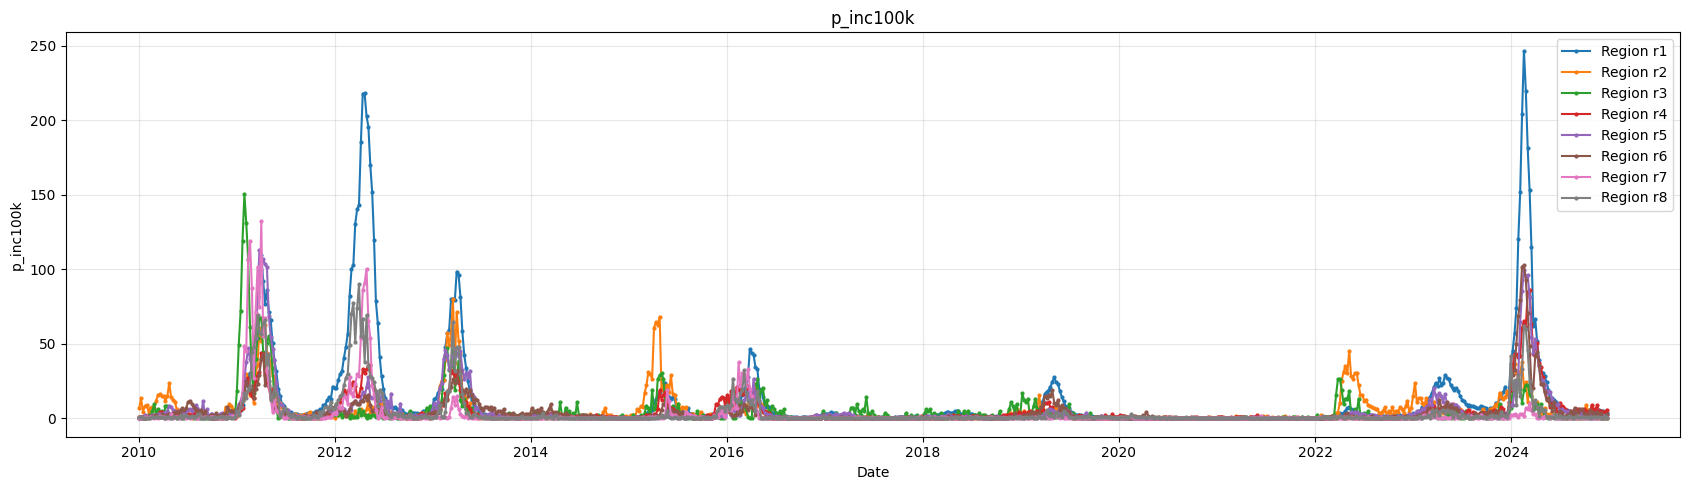

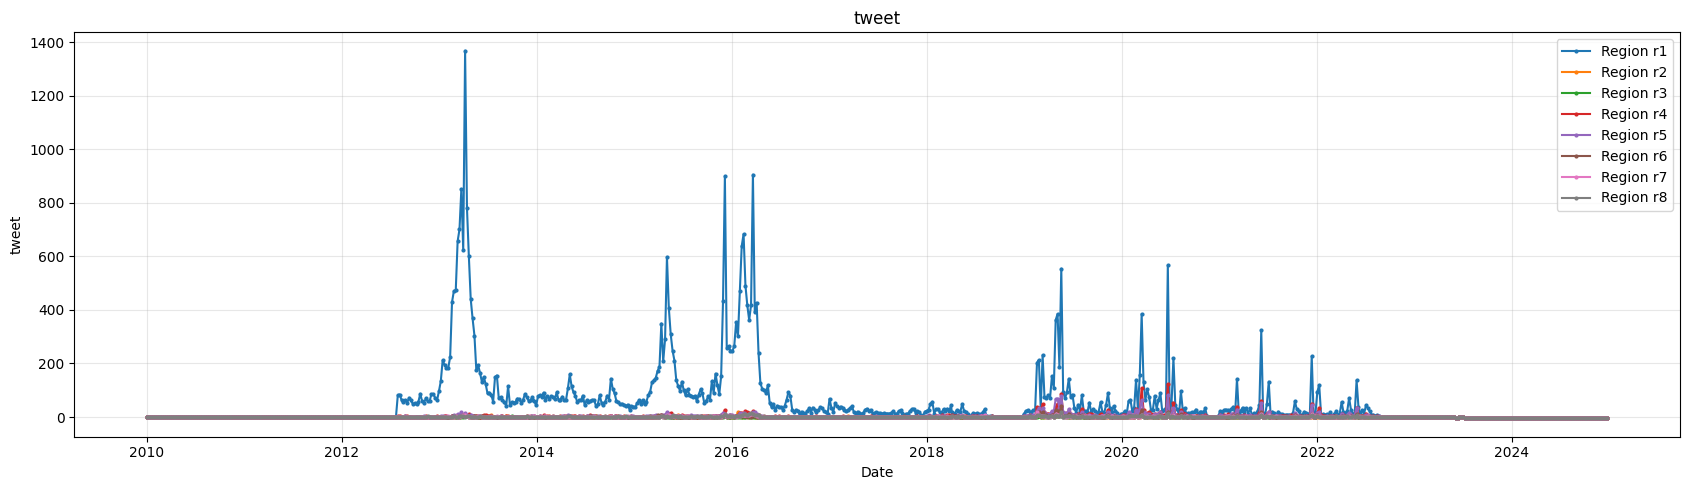

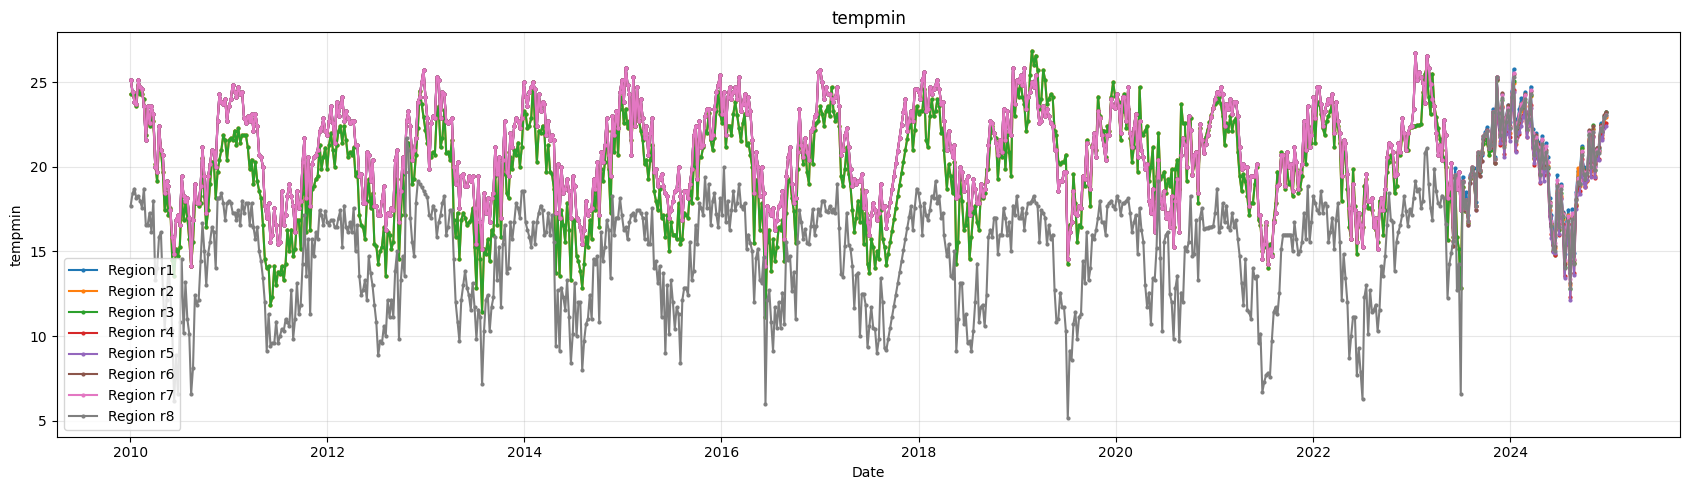

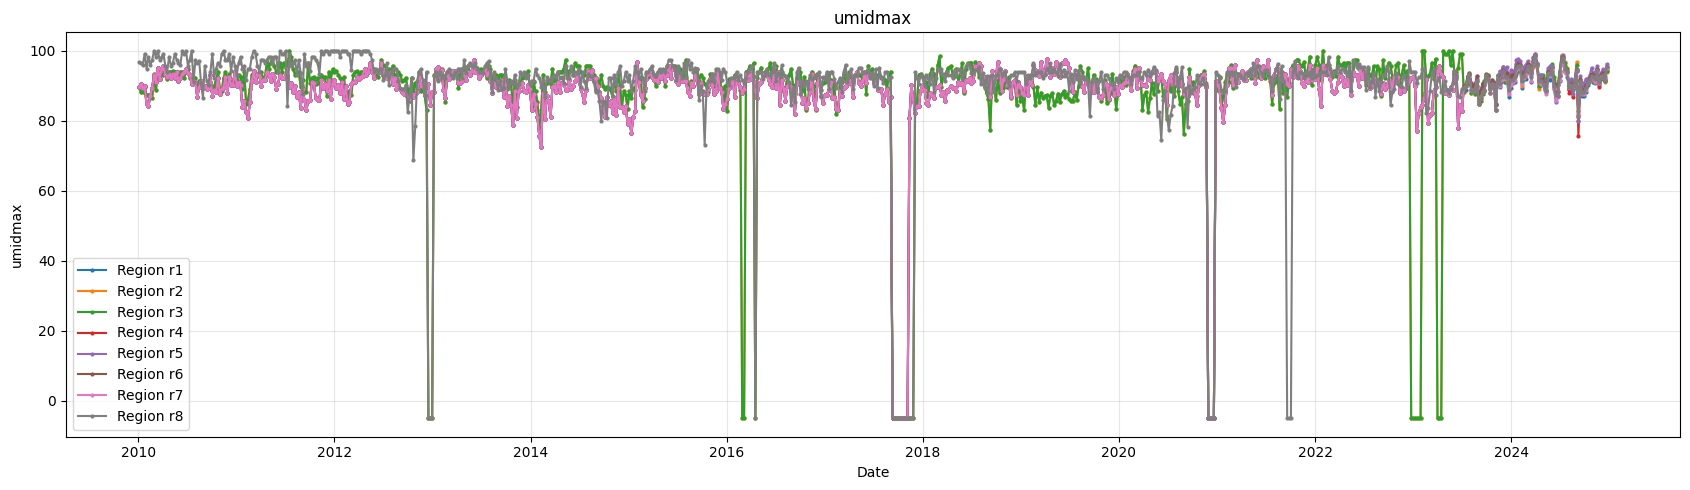

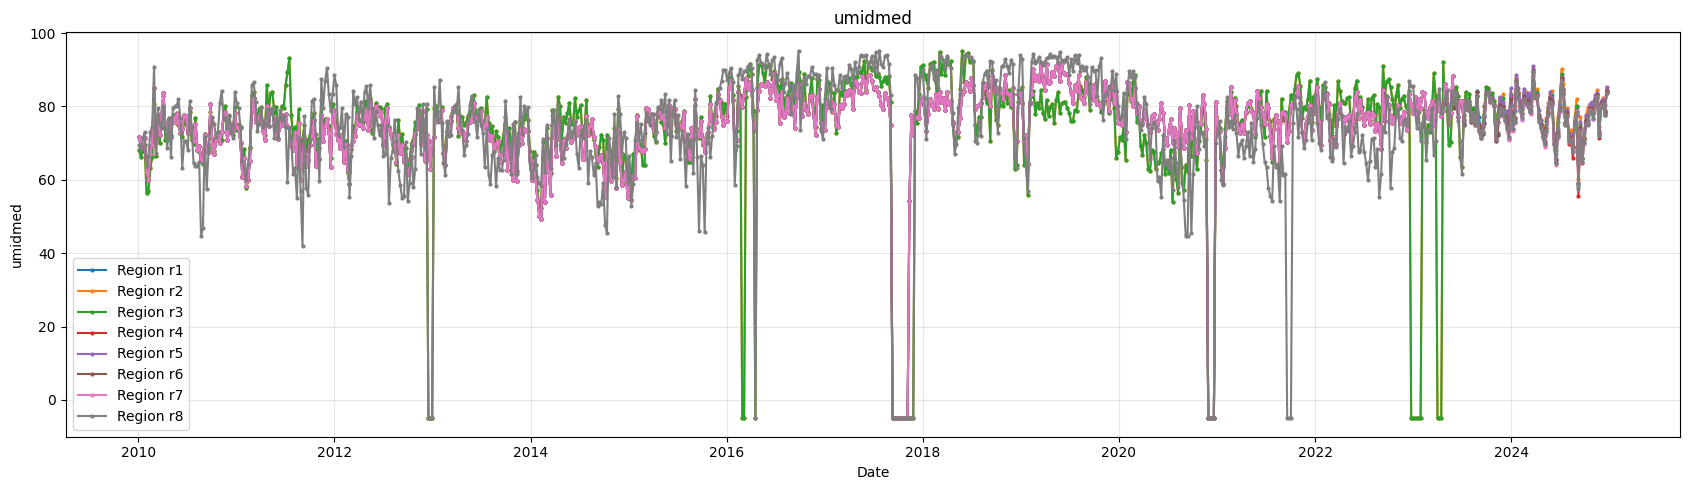

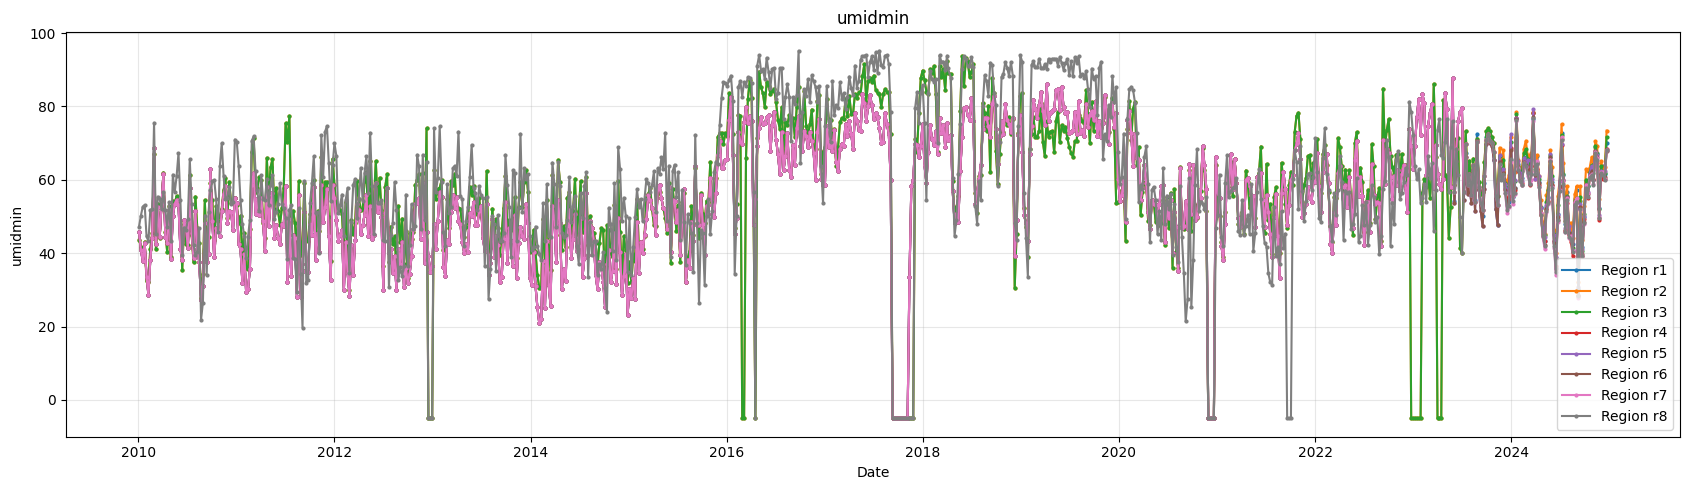

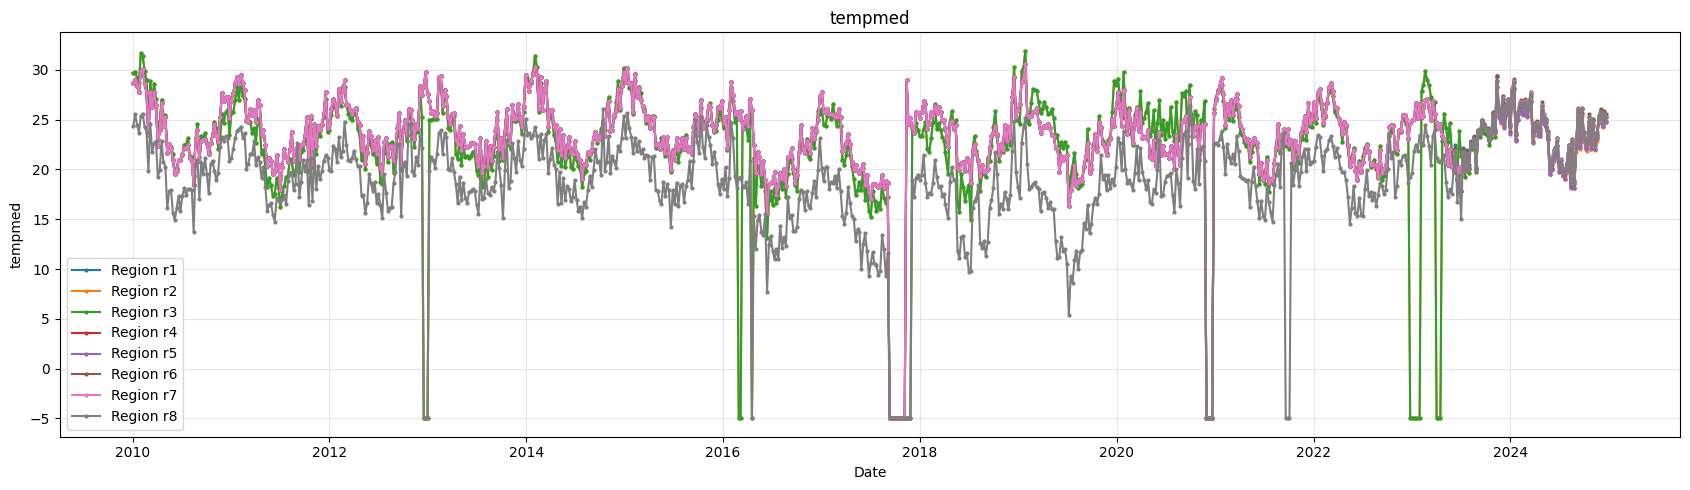

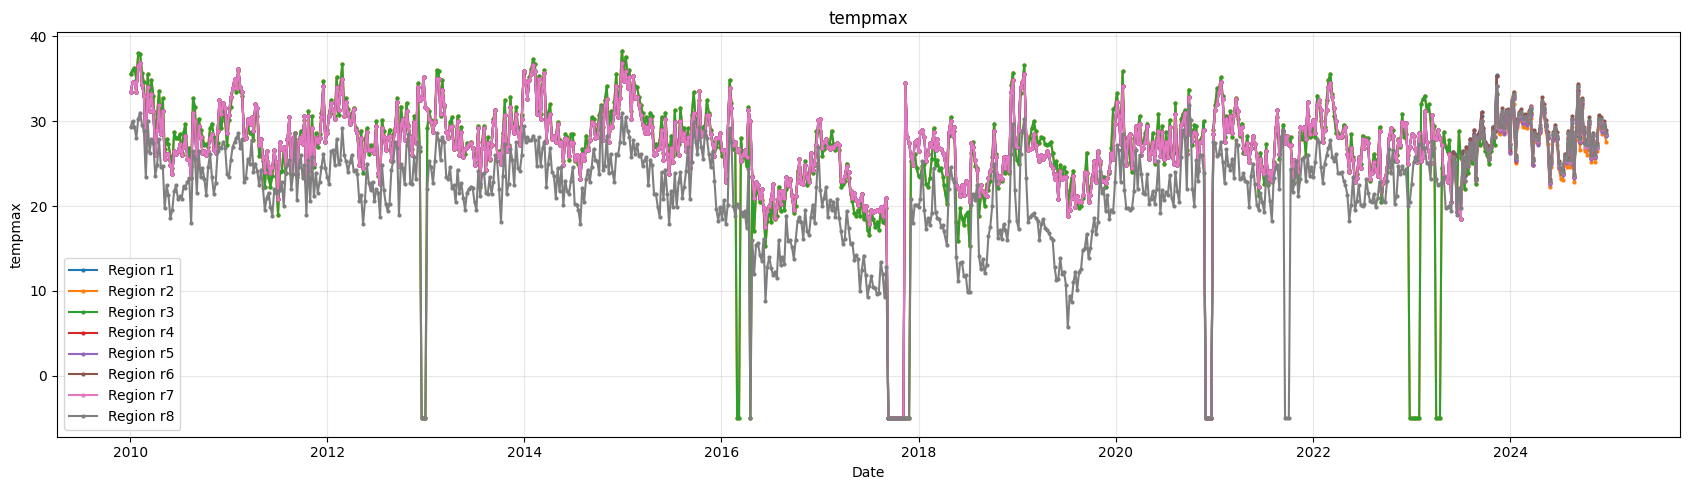

In [12]:
vars_to_plot = ['p_inc100k','tweet','tempmin','umidmax','umidmed','umidmin','tempmed','tempmax']
plot_ts(all_filt, vars_to_plot, date_col="data_iniSE", region_col="region", na_fill=-5)

In [13]:
## From the graph above, tweet data seems to exists for only the rio, therefore I will not include tweets
all_filt2 = all_filt.copy()
all_filt2.drop(columns=['tweet'], inplace=True)
all_filt2.head(5)

,data_iniSE,nivel,p_inc100k,Rt,p_rt1,tempmin,umidmax,umidmed,umidmin,tempmed,tempmax,region
0,2024-12-22,2,3.667454,0.773770,0.001278,23.243929,94.555071,83.822829,70.152700,25.307686,28.246443,r1
1,2024-12-15,2,4.074949,0.811507,0.005254,23.011457,91.336371,77.770914,61.547200,25.614957,29.473357,r1
2,2024-12-08,2,5.071048,1.020922,0.605330,22.294214,92.493014,81.153257,63.694529,24.645686,28.808371,r1
3,2024-12-01,2,5.055956,1.088959,0.860020,22.561500,92.057057,80.579243,63.887829,25.732543,29.777914,r1
4,2024-11-24,1,5.342711,1.166878,0.975968,21.103643,90.078486,72.824814,52.232800,24.950714,29.700743,r1


## Baseline Model 1
Tomorrow is the same as today

In [14]:
data_b1 = all_filt2[['data_iniSE', 'nivel', 'region']].copy()
data_b1['pred'] = data_b1['nivel'].shift(-1)
data_b1 = data_b1[data_b1['data_iniSE'] != pd.to_datetime('2010-01-03')]
data_b1 = data_b1.dropna()

In [15]:
data_b1.head(5)

,data_iniSE,nivel,region,pred
0,2024-12-22,2,r1,2.0
1,2024-12-15,2,r1,2.0
2,2024-12-08,2,r1,2.0
3,2024-12-01,2,r1,1.0
4,2024-11-24,1,r1,1.0


In [16]:
def eval(y_true, y_pred, region=None):
    acc = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred, average="weighted", zero_division=0), 3)
    recall = round(recall_score(y_true, y_pred, average="weighted", zero_division=0), 3)
    f1 = round(f1_score(y_true, y_pred, average="weighted", zero_division=0), 3)

    row = pd.DataFrame([{
        "region": region,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }])
    return row

In [17]:
reg = data_b1['region'].unique().tolist()
eval_baseline = pd.DataFrame()

for _, r in enumerate(reg):
    data = data_b1[data_b1['region']==r]
    eval_baseline = pd.concat([eval_baseline, eval(data['nivel'], data['pred'], r)], ignore_index=True)

In [18]:
eval_baseline

,region,accuracy,precision,recall,f1
0,r1,0.916,0.916,0.916,0.916
1,r2,0.940,0.940,0.940,0.940
2,r3,0.941,0.941,0.941,0.941
3,r4,0.894,0.894,0.894,0.894
4,r5,0.909,0.909,0.909,0.909
5,r6,0.902,0.901,0.902,0.901
6,r7,0.962,0.962,0.962,0.962
7,r8,0.972,0.972,0.972,0.972


## Data Preparation For LSTM

In [19]:
def prep(df):

  df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])
  df = df.sort_values(['region','data_iniSE'])
  pwide = df.pivot_table(index='data_iniSE', columns='region', values='p_inc100k')
  pwide = pwide.add_prefix('pinc_')
  df = df.merge(pwide, left_on='data_iniSE', right_index=True, how='left')
  df.drop(columns=['p_inc100k', 'Rt', 'p_rt1'], inplace=True)

  # Split between training-validation data and testing data
  reg = df['region'].unique()
  df_tr, df_te = [],[]
  # df_train, df_test = pd.DataFrame(), pd.DataFrame()
  for i, r in enumerate (reg):
    df_split = df[df['region'] == r].copy()
    n = len(df_split)
    tr_end = int(n * 0.75);
    print(f"region: {r}, total week: {n}, train untill week: {tr_end}")
    df_tr.append(df_split.iloc[:tr_end])
    df_te.append(df_split.iloc[tr_end:])

  return pd.concat(df_tr, ignore_index=True), pd.concat(df_te, ignore_index=True)

In [20]:
data_ml, data_test = prep(all_filt2)
data_ml.head(5)

region: r1, total week: 782, train untill week: 586
region: r2, total week: 782, train untill week: 586
region: r3, total week: 782, train untill week: 586
region: r4, total week: 782, train untill week: 586
region: r5, total week: 782, train untill week: 586
region: r6, total week: 782, train untill week: 586
region: r7, total week: 782, train untill week: 586
region: r8, total week: 782, train untill week: 586


,data_iniSE,nivel,tempmin,umidmax,umidmed,umidmin,tempmed,tempmax,region,pinc_r1,pinc_r2,pinc_r3,pinc_r4,pinc_r5,pinc_r6,pinc_r7,pinc_r8
0,2010-01-03,1,25.142857,89.714286,71.687877,45.857143,28.714322,33.428571,r1,0.444588,6.675617,0.0,0.971697,0.432608,0.422917,0.000000,0.566351
1,2010-01-10,1,24.428571,90.571429,68.771851,40.857143,29.021947,34.571429,r1,0.652063,13.351233,0.0,0.607311,0.540760,0.634375,0.000000,1.132702
2,2010-01-17,2,23.857143,89.285714,70.101537,37.857143,28.344092,34.571429,r1,0.681702,4.450411,0.0,0.728773,0.648912,0.211459,0.000000,0.000000
3,2010-01-24,2,23.714286,89.857143,71.274127,42.857143,27.822510,33.428571,r1,0.696522,8.159087,0.0,0.485848,2.487498,0.211459,0.614655,0.000000
4,2010-01-31,2,25.142857,84.857143,62.218228,33.571429,29.935030,36.428571,r1,1.007734,8.900823,0.0,1.093159,0.648912,1.268751,1.229309,0.000000


In [21]:
def make_window(df, target_col, win_size=12, horizon=1, mask_val=-5.0):

    df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])
    df = df.sort_values(['region', 'data_iniSE'])

    feature_cols = [c for c in df.columns if c not in ['region', 'data_iniSE', target_col]]

    X_parts, y_parts, meta_parts = [], [], []
    stats_out = {}

    for reg, g in df.groupby('region'):
        g = g.sort_values('data_iniSE').reset_index(drop=True)
        if len(g) < win_size + horizon:
            continue

        X_raw = g[feature_cols].to_numpy(float)                    # (N, F)
        yarr  = g[target_col].to_numpy()                           # (N,)
        darr  = g['data_iniSE'].to_numpy(dtype='datetime64[ns]')   # (N,)

        # Scaling data
        mu = np.nanmean(X_raw, axis=0)
        sigma = np.nanstd(X_raw, axis=0)
        sigma[sigma == 0] = 1.0
        stats_out[reg] = {'mu': mu, 'sigma': sigma}

        X_scaled = (X_raw - mu) / sigma
        X_scaled[np.isnan(X_scaled)] = mask_val  # mask any NaNs

        # Window and alignment
        Xw_full = sliding_window_view(X_scaled, window_shape=win_size, axis=0)  # (N-win+1, win, F)
        Yf_full = sliding_window_view(yarr,   window_shape=horizon, axis=0)     # (N-h+1, h)
        Df_full = sliding_window_view(darr,   window_shape=horizon, axis=0)     # (N-h+1, h)

        Yw = Yf_full[win_size:]
        Dw = Df_full[win_size:]
        Xw = Xw_full[:len(Yw)]

        # Meta data
        window_end = darr[win_size-1 : win_size-1 + len(Xw)]
        meta = pd.DataFrame({"region": reg, "window_end": window_end})
        for k in range(horizon):
            meta[f"date_h{k+1}"] = Dw[:, k]

        X_parts.append(Xw)
        y_parts.append(Yw)
        meta_parts.append(meta)


    X = np.concatenate(X_parts, axis=0)
    Y = np.concatenate(y_parts,  axis=0)
    M = pd.concat(meta_parts, ignore_index=True)

    return X, Y, M, stats_out

In [22]:
# def build_lstm(input_shape, n_classes, units=64, dropout=0.3, add_second=False, second_units=None,
#                loss='sparse_categorical_crossentropy', lr=1e-3, mask_val=-5.0):

#     model = Sequential()
#     model.add(Masking(mask_value=mask_val, input_shape=input_shape))

#     # 1st layer
#     model.add(Bidirectional(LSTM(units, return_sequences=add_second, dropout=dropout)))
#     model.add(Dropout(dropout))

#     # if needed, can add another layer
#     if add_second:
#         model.add(LSTM(second_units or units, return_sequences=False,dropout=dropout))
#         model.add(Dropout(dropout))

#     model.add(Dense(n_classes, activation='softmax'))

#     model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])
#     return model


In [23]:
def build_lstm(input_shape, n_classes, horizon, units=64, dropout=0.3, add_second=False,
                     second_units=None, loss='sparse_categorical_crossentropy',lr=1e-3, mask_val=-5.0):

    # To avoid some conflict in data type
    units = int(units)
    horizon = int(horizon)
    su = None
    if second_units is not None:
        if not (isinstance(second_units, float) and np.isnan(second_units)):
            su = int(second_units)

    model = Sequential()
    model.add(Masking(mask_value=mask_val, input_shape=input_shape))

    model.add(Bidirectional(LSTM(units, return_sequences=False, dropout=dropout)))
    model.add(Dropout(dropout))

    model.add(RepeatVector(horizon))

    model.add(LSTM(su if su is not None else units, return_sequences=True, dropout=dropout))
    if add_second:
        model.add(Dropout(dropout))
        model.add(LSTM(su if su is not None else units, return_sequences=True, dropout=dropout))

    model.add(TimeDistributed(Dense(n_classes, activation='softmax')))
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])
    return model

## Gridsearch

In [24]:
def gridsearch(dfr, param_grid, T=12, horizon=1, mask_val=-5.0, epochs=50, batch_size=64, patience=8):

    # Change code from 1 - 4 to 0 - 3
    le = LabelEncoder()
    dfr = dfr.copy()
    dfr["nivel_enc"] = le.fit_transform(dfr["nivel"].astype(int))
    dfr.drop(columns=["nivel"], inplace=True)
    n_classes = len(le.classes_)

    # Split train/val
    n = len(dfr)
    tr_end = int(n * 0.60)
    df_tr, df_va = dfr.iloc[:tr_end], dfr.iloc[tr_end:]

    # Build windows, keep the meta (info about the date and the region)
    Xtr, ytr, meta_tr, _ = make_window(df_tr, target_col="nivel_enc", win_size=T, horizon=horizon, mask_val=mask_val)
    Xva, yva, meta_va, _ = make_window(df_va, target_col="nivel_enc", win_size=T, horizon=horizon, mask_val=mask_val)

    # Custom class weight
    cw = {0: 1, 1: 1, 2: 1, 3: 0.8}


    # Initialization
    summaries = []
    for params in ParameterGrid(param_grid):

        if not params["add_second"] and params["second_units"] is not None:
            continue

        print("Running config:", params)
        loss_name = params["loss_name"]

        # Different processing due to categorical requires one-hot input
        if params['loss_name'] == 'sparse_categorical_crossentropy':
            ytr_fit = ytr                      # (N, H)
            yva_fit = yva
        else:
            ytr_fit = to_categorical(ytr, num_classes=n_classes)  # (N, H, C)
            yva_fit = to_categorical(yva, num_classes=n_classes)

        model = build_lstm(
            input_shape=(Xtr.shape[1], Xtr.shape[2]),
            n_classes=n_classes,
            horizon=horizon,
            units=params["units"],
            dropout=params["dropout"],
            add_second=params["add_second"],
            second_units=params["second_units"],
            loss=params["loss_name"],
            lr=1e-3,
            mask_val=mask_val,
        )

        es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
        hist = model.fit(
            Xtr, ytr_fit,
            validation_data=(Xva, yva_fit),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[es])

        # Val
        probs = model.predict(Xva, verbose=0)          # (N, H, C)
        preds = probs.argmax(axis=-1)                  # (N, H) class per step

        # ground truth (N, H)
        if params['loss_name'] == 'sparse_categorical_crossentropy':
            yva_true = yva if yva.ndim == 2 else yva[:, None]
        else:
            yva_true = yva.argmax(axis=-1)

        best_vloss = float(np.min(hist.history.get("val_loss", [np.nan])))

        # Metrics on flattened arrays across all steps
        val_acc = float((preds.ravel() == yva_true.ravel()).mean())
        val_f1  = float(f1_score(yva_true.ravel(), preds.ravel(), average='weighted'))

        summaries.append({
            **params,
            "val_acc": val_acc,
            "val_f1": val_f1,
            "val_loss": best_vloss,
            "n_train_windows": int(len(Xtr)),
            "n_val_windows": int(len(Xva)),
        })

    summary_df = pd.DataFrame(summaries).sort_values("val_f1", ascending=False).reset_index(drop=True)
    return summary_df

In [ ]:
param_grid = {
    "units": [32, 64],
    "dropout": [0.2, 0.3],
    "loss_name": ["sparse_categorical_crossentropy"],#, "categorical_crossentropy"],
    "add_second": [False, True],
    "second_units": [None, 32],
}

hor_gs = []
for h in range(1, 5):
    print(f"Horizon: {h}")
    summary_df = gridsearch(data_ml, param_grid, T=12, horizon=h)
    hor_gs.append(summary_df)

Horizon: 1
Running config: {'add_second': False, 'dropout': 0.2, 'loss_name': 'sparse_categorical_crossentropy', 'second_units': None, 'units': 32}
Running config: {'add_second': False, 'dropout': 0.2, 'loss_name': 'sparse_categorical_crossentropy', 'second_units': None, 'units': 64}
Running config: {'add_second': False, 'dropout': 0.3, 'loss_name': 'sparse_categorical_crossentropy', 'second_units': None, 'units': 32}


In [ ]:
hor_gs[0]

In [ ]:
hor_gs[1]

In [ ]:
hor_gs[2]

In [ ]:
hor_gs[3]

In [ ]:
# Manually writing down the params bcs i don't want to rerun the gridsearch and forgot to save the results
hor_gs = [
    # Horizon 1
    pd.DataFrame([{
        "add_second": True,
        "dropout": 0.2,
        "loss_name": "sparse_categorical_crossentropy",
        "second_units": 32.0,
        "units": 64,
    }]),
    # Horizon 2
    pd.DataFrame([{
        "add_second": False,
        "dropout": 0.3,
        "loss_name": "sparse_categorical_crossentropy",
        "second_units": np.nan,
        "units": 64,
    }]),
    # Horizon 3
    pd.DataFrame([{
        "add_second": True,
        "dropout": 0.3,
        "loss_name": "sparse_categorical_crossentropy",
        "second_units": 32.0,
        "units": 64,
    }]),
    # Horizon 4
    pd.DataFrame([{
        "add_second": True,
        "dropout": 0.2,
        "loss_name": "sparse_categorical_crossentropy",
        "second_units": 32.0,
        "units": 32,
    }]),
]


In [ ]:
def run_lstm(dfr, params, T=12, horizon=1, mask_val=-5.0, epochs=50, batch_size=64, patience=8):

    # Change code from 1 - 4 to 0 - 3
    le = LabelEncoder()
    dfr = dfr.copy()
    dfr["nivel_enc"] = le.fit_transform(dfr["nivel"].astype(int))
    dfr.drop(columns=["nivel"], inplace=True)
    n_classes = len(le.classes_)

    # Split train/val
    n = len(dfr)
    tr_end = int(n * 0.60)

    df_tr, df_va = dfr.iloc[:tr_end], dfr.iloc[tr_end:]

    # Build windows, keep the meta (info about the date and the region)
    Xtr, ytr, meta_tr, _ = make_window(df_tr, target_col="nivel_enc",  win_size=T, horizon=horizon, mask_val=mask_val)
    Xva, yva, meta_va, _ = make_window(df_va, target_col="nivel_enc",  win_size=T, horizon=horizon, mask_val=mask_val)

    # Custom class weight
    cw = {0: 1, 1: 1, 2: 1, 3: 0.8}

    # Different processing due to categorical requires one-hot input
    if params['loss_name'] == 'sparse_categorical_crossentropy':
        ytr_fit = ytr                      # (N, H)
        yva_fit = yva
    else:
        ytr_fit = to_categorical(ytr, num_classes=n_classes)  # (N, H, C)
        yva_fit = to_categorical(yva, num_classes=n_classes)

    model = build_lstm(
        input_shape=(Xtr.shape[1], Xtr.shape[2]),
        n_classes=n_classes,
        horizon=horizon,
        units=params["units"],
        dropout=params["dropout"],
        add_second=params["add_second"],
        second_units=params["second_units"],
        loss=params["loss_name"],
        lr=1e-3,
        mask_val=mask_val,
    )

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
    hist = model.fit(
        Xtr, ytr_fit,
        validation_data=(Xva, yva_fit),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        # callbacks=[es],
    )

    # Val
    probs = model.predict(Xva, verbose=0)
    preds = probs.argmax(axis=-1)

    yva_true = yva if yva.ndim == 2 else yva.argmax(axis=-1)
    val_acc = (preds == yva_true).mean()
    val_f1 = f1_score(yva_true.ravel(), preds.ravel(), average='weighted')


    return model, {"val_acc": val_acc, "val_f1": val_f1, "history": hist.history}

In [ ]:
i = 1
hor_run = []
hor_mod = []

# Different horizon loop
for i in range(0,4):
    print(f"Horizon: {i+1}")
    param_grid_best = {
    "units": hor_gs[i]['units'][0],
    "dropout": hor_gs[i]['dropout'][0],
    "loss_name": hor_gs[i]['loss_name'][0],
    "add_second": hor_gs[i]['add_second'][0],
    "second_units": hor_gs[i]['second_units'][0],}
    model, results_rr = run_lstm(data_ml, param_grid_best, horizon=i+1, T= 12)

    hor_run.append(results_rr)
    hor_mod.append(model)


## Recap

In [ ]:
metrics = list(hor_run[0]['history'].keys())
rows, cols = 2, 2
total_slots = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
k = 0

for r in range(rows):
    for c in range(cols):
        ax = axes[r, c]
        m = metrics[k]
        for i in range(4):
            ax.plot(hor_run[i]['history'][m], label=f"Hor: {i+1}")
        ax.set_title(m)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(m)
        ax.grid(True)
        ax.legend()
        k += 1

plt.tight_layout()
plt.show()

In [ ]:
rows, cols = 4, 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

for i in range(rows):
    ax_acc = axes[i, 0]
    ax_acc.plot(hor_run[i]['history']['accuracy'], "o-", label="Train Acc", markersize=3)
    ax_acc.plot(hor_run[i]['history']['val_accuracy'], "o-", label="Val Acc", markersize=3)
    ax_acc.set_title(f"Horizon {i+1} - Accuracy")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.grid(True)
    ax_acc.legend()

    ax_loss = axes[i, 1]
    ax_loss.plot(hor_run[i]['history']['loss'], "o-", label="Train Loss", markersize=3)
    ax_loss.plot(hor_run[i]['history']['val_loss'], "o-", label="Val Loss", markersize=3)
    ax_loss.set_title(f"Horizon {i+1} - Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.grid(True)
    ax_loss.legend()

plt.tight_layout()
plt.show()


## Test

In [ ]:
def predicting(hor_mod, data_test, make_window, target_col="nivel",win_size=12, mask_val=-5.0):

    pred_data = []
    for i, model in enumerate(hor_mod, start=1):
        H = i
        Xte, yte, meta_te, _ = make_window(
            data_test, target_col=target_col, win_size=win_size, horizon=H, mask_val=mask_val
        )

        probs = model.predict(Xte, verbose=0)       # (N, H, C)
        preds = probs.argmax(axis=-1)               # (N, H)

        yte_enc = np.asarray(yte)
        if yte_enc.ndim == 1:
            yte_enc = yte_enc[:, None]
        if yte_enc.min() >= 1:
            yte_enc = yte_enc - 1

        m = meta_te.copy()
        N, C = probs.shape[0], probs.shape[-1]
        idx = np.arange(N)

        for h in range(H):
            lead = h + 1
            m[f"y_true_lead{lead}"] = yte_enc[:, h]
            m[f"y_pred_lead{lead}"] = preds[:, h]
            # mean cross-entropy needs per-sample CE, so we can aggregate later
            p_true = probs[idx, h, yte_enc[:, h]]
            m[f"loss_ce_lead{lead}"] = -np.log(p_true + 1e-12)

        m["horizon_model"] = H
        pred_data.append(m)

    return pred_data

In [ ]:
def metrics_overall_target_lead(pred_data):

    rows = []
    for H, df in enumerate(pred_data, start=1):
        lead = H
        y_true = df[f"y_true_lead{lead}"].to_numpy()
        y_pred = df[f"y_pred_lead{lead}"].to_numpy()
        acc = accuracy_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred, average="weighted")
        ce  = df[f"loss_ce_lead{lead}"].mean() if f"loss_ce_lead{lead}" in df else np.nan
        rows.append({
            "horizon": H, "lead": lead,
            "accuracy": acc, "f1_weighted": f1, "loss_ce": ce,
            "support": len(df),
        })
    return pd.DataFrame(rows).sort_values(["horizon","lead"]).reset_index(drop=True)

In [ ]:
def metrics_byregion_target_lead(pred_data):

    rows = []
    for H, df in enumerate(pred_data, start=1):
        lead = H
        for region, grp in df.groupby("region"):
            y_true = grp[f"y_true_lead{lead}"].to_numpy()
            y_pred = grp[f"y_pred_lead{lead}"].to_numpy()
            acc = accuracy_score(y_true, y_pred)
            f1  = f1_score(y_true, y_pred, average="weighted")
            ce  = grp[f"loss_ce_lead{lead}"].mean() if f"loss_ce_lead{lead}" in grp else np.nan
            rows.append({
                "horizon": H, "lead": lead, "region": region,
                "accuracy": acc, "f1_weighted": f1, "loss_ce": ce,
                "support": len(grp),
            })
    return pd.DataFrame(rows).sort_values(["horizon","lead","region"]).reset_index(drop=True)

In [ ]:
def metrics_overall_all_leads(pred_data):
    rows = []
    for H, df in enumerate(pred_data, start=1):
        for lead in range(1, H+1):
            y_true = df[f"y_true_lead{lead}"].to_numpy()
            y_pred = df[f"y_pred_lead{lead}"].to_numpy()
            acc = accuracy_score(y_true, y_pred)
            f1  = f1_score(y_true, y_pred, average="weighted")
            ce  = df[f"loss_ce_lead{lead}"].mean() if f"loss_ce_lead{lead}" in df else np.nan
            rows.append({
                "horizon": H, "lead": lead,
                "accuracy": acc, "f1_weighted": f1, "loss_ce": ce,
                "support": len(df),
            })
    return pd.DataFrame(rows).sort_values(["horizon","lead"]).reset_index(drop=True)

In [ ]:
def metrics_byregion_all_leads(pred_data):
    rows = []
    for H, df in enumerate(pred_data, start=1):
        for lead in range(1, H+1):
            for region, grp in df.groupby("region"):
                y_true = grp[f"y_true_lead{lead}"].to_numpy()
                y_pred = grp[f"y_pred_lead{lead}"].to_numpy()
                acc = accuracy_score(y_true, y_pred)
                f1  = f1_score(y_true, y_pred, average="weighted")
                ce  = grp[f"loss_ce_lead{lead}"].mean() if f"loss_ce_lead{lead}" in grp else np.nan
                rows.append({
                    "horizon": H, "lead": lead, "region": region,
                    "accuracy": acc, "f1_weighted": f1, "loss_ce": ce,
                    "support": len(grp),
                })
    return pd.DataFrame(rows).sort_values(["horizon","lead","region"]).reset_index(drop=True)

In [ ]:
pred_data = predicting(hor_mod, data_test, make_window, target_col="nivel", win_size=12, mask_val=-5.0)
overall_targetlead = metrics_overall_target_lead(pred_data)
byregion_targetlead = metrics_byregion_target_lead(pred_data)
overall_allleads = metrics_overall_all_leads(pred_data)
byregion_allleads = metrics_byregion_all_leads(pred_data)

In [ ]:
overall_targetlead

In [ ]:
overall_allleads

In [ ]:
byregion_allleads

In [ ]:
def plot_results(region, data):

    results = data[data['region']==region]
    y_true = results["y_true_lead1"]
    y_pred = results["y_pred_lead1"]
    dates  = results["date_h1"]

    acc       = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall    = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1        = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # lead_rate = results.get("lead_rate", None)
    # lead_hits = results.get("lead_hits", None)
    # possible_hits = results.get("possible_hits", None)

    print(f"\nRegion: {region}")
    print(f"Test Accuracy: {acc:.3f} | Weighted Precision: {precision:.3f} | Weighted Recall: {recall:.3f} | Weighted F1: {f1:.3f}")
    # print(f"Lead Hit Rate (alarm before outbreak): {lead_rate:.3f} ({lead_hits}/{possible_hits})")

    # Plot the time series
    plt.figure(figsize=(14, 4))
    plt.plot(dates, y_true, label="Actual", marker='o', markersize=3)
    plt.plot(dates, y_pred, label="Predicted", marker='x', markersize=3)
    # plt.title(f"Region: {region} — Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Nivel")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # CM
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    # plt.title(f"Region: {region} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


In [ ]:
plot_results('r1', pred_data[0])